# Mobile sensing Lab 2 - Python framework for data processing - Part 1 (Data engineering)

We will develop a machine learning pipeline for activity recognition from smartphone sensor data (acceleration, gravity, etc.). The first part of the pipeline contains:

1. Exploratory data analysis - check data quality and calculate informative statistics about the dataset;
2. Segmentation and filtering - segment the data into windows (e.g., 4 seconds data) and try different filtering methods to improve the sensor data quality i.e., remove noise;

The second part of the pipeline contains:
3. Feature extraction and visualization - calculate features for each segment, which will be used as input to machine learning models;
4. Building and evaluation of machine learning models.

## 1. Import data and check data quality/validity

The dataset that we are going to use is downloaded form: https://github.com/mmalekzadeh/motion-sense.

The dataset includes raw data from 4 sensors, 3-axis per sensor, thus 4x3 = 12 time-series. More specifically, the sensors are:
1. Orientation sensor - measures degrees of rotation that a device makes around all three physical axes x, y, z (roll, pitch, yaw);
2. Gravity sensor - measures the force of gravity in m/s2 that is applied to a device on all three physical axes x, y and z; 
3. Accelerometer - measures the acceleration force in m/s2 that is applied to a device on all three physical axes x, y, and z, including the force of gravity;
4. Gyroscope sensors - measures a device's rate of rotation in rad/s around each of the three physical axes x, y, and z. 
    
  
The dataset is collected with an iPhone 6s kept in the participant's front pocket. All data is collected in 50Hz sample rate. A total of 24 participants in a range of gender, age, weight, and height performed 6 activities in 15 trials in the same environment and conditions: downstairs, upstairs, walking, jogging, sitting, and standing. 

In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import seaborn as sns

In [3]:
#import the data
data_path = os.getcwd()+"/data/motion-sense-processed.csv"
print("Loading data from:",data_path)
data = pd.read_csv(data_path,header=0,index_col =0)
print("Done. Loaded data frame (rows, columns):",data.shape, "")

Loading data from: /Users/erikjanezic/Documents/Faculty/arp/labs2/data/motion-sense-processed.csv
Done. Loaded data frame (rows, columns): (1412865, 19) 


/Users/erikjanezic/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
data.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,weight,height,age,gender,trial
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,0.0,0.0,102.0,188.0,46.0,1.0,1.0
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,0.0,0.0,102.0,188.0,46.0,1.0,1.0
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,0.0,0.0,102.0,188.0,46.0,1.0,1.0
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,0.0,0.0,102.0,188.0,46.0,1.0,1.0
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,0.0,0.0,102.0,188.0,46.0,1.0,1.0


#### 1.1 Check whether the data contains: 
- 4 sensors (and 3 axis per sensor;
- 24 participants;
- 6 activities;
- 15 trials.

In [5]:
sensor_columns = data.columns[:12]
info_coumns = data.columns[12:]
print("Number of unique participants:", len(data.id.unique()))
print("Number of unique activitues:", len(data.act.unique()))
print("Number of encoded trails:", len(data.trial.unique()))
print("Number of columns", len(data.columns))
print("Number of info_coumns:", len(info_coumns),info_coumns.values)
print("Number of sensor_columns:", len(sensor_columns),sensor_columns.values)
print()

Number of unique participants: 24
Number of unique activitues: 6
Number of encoded trails: 15
Number of columns 19
Number of info_coumns: 7 ['act' 'id' 'weight' 'height' 'age' 'gender' 'trial']
Number of sensor_columns: 12 ['attitude.roll' 'attitude.pitch' 'attitude.yaw' 'gravity.x' 'gravity.y'
 'gravity.z' 'rotationRate.x' 'rotationRate.y' 'rotationRate.z'
 'userAcceleration.x' 'userAcceleration.y' 'userAcceleration.z']



#### 1.2 Let's answer the following questions:
- What is the average age (and standard deviation) of the participants?
- What is the average age (and standard deviation) of the females/males?
- Plot average duration of each trial (in seconds).
- Add one more column to the data frame which will represent the magnitude of the acceleration data. The magnitude is calcualted as sqrt(accX*accX + accY*accY+ accZ*accZ).
- Plot the histogram of the magnitude.

In [6]:
mean_age = data.age.mean()
std_age = data.age.std()
print("Average age (std): ",mean_age,std_age)

Average age (std):  28.832020752159618 5.303462687553288


In [7]:
# To answer some of the questions we will reshape the data.
# For example, the 'groupby' function allows aggregation (summarisation) of the data. 
# We will perform aggregation for each participant (by participants' ids) using mean values. 
data_aggregated = data.groupby('id').mean()
data_aggregated

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,weight,height,age,gender,trial
id,,,,,,,,,,,,,,,,,,
0.0,0.206307,-0.867166,0.545989,0.118094,0.687610,-0.300272,0.005704,0.015463,0.047610,0.015927,0.062496,-0.034511,3.237771,102.0,188.0,46.0,1.0,7.895285
1.0,0.958013,-0.879242,0.258318,0.265337,0.698088,-0.342070,0.017560,0.004653,-0.014151,0.020268,0.073154,0.081058,2.750333,72.0,180.0,28.0,1.0,7.900480
2.0,0.935801,-1.105530,-0.091239,0.262779,0.837430,-0.262999,0.000793,0.007178,0.011634,-0.001287,0.016775,0.025547,2.926702,48.0,161.0,28.0,0.0,7.373555
3.0,-0.562115,-1.118347,-0.495977,0.068748,0.859364,-0.125911,0.006014,0.014585,0.069774,-0.006173,0.078793,0.057828,2.842222,90.0,176.0,31.0,1.0,7.594496
4.0,-1.162863,-0.905299,0.095983,-0.171378,0.688836,0.319923,-0.003419,-0.006095,-0.011758,0.000047,0.000836,0.001119,3.055793,48.0,164.0,23.0,0.0,7.468910
5.0,-0.464942,-1.024897,-0.259495,0.022187,0.771850,-0.261259,0.016975,0.028555,0.041184,-0.013026,0.053548,0.055494,2.918260,76.0,180.0,28.0,1.0,7.880791
6.0,0.227899,-0.964709,-0.976021,0.187387,0.711051,-0.110147,-0.004964,-0.003463,0.012827,-0.006062,0.021034,0.026783,2.996312,62.0,175.0,30.0,0.0,7.537111
7.0,0.429300,-1.111145,0.150577,0.175236,0.851363,-0.263622,0.001397,0.011577,0.009748,-0.012030,0.015210,0.035132,2.954534,52.0,161.0,24.0,0.0,7.612248
8.0,-0.282596,-1.011880,-0.629428,0.096238,0.776274,-0.307305,0.008438,0.010944,0.030366,-0.004859,0.060731,0.079189,2.974989,93.0,190.0,32.0,1.0,7.396913


In [8]:
f_age_mean = data_aggregated[data_aggregated.gender==0].age.mean()
f_age_std = data_aggregated[data_aggregated.gender==0].age.std()

m_age_mean = data_aggregated[data_aggregated.gender==1].age.mean()
m_age_std = data_aggregated[data_aggregated.gender==1].age.std()

print("Average female age (std): ",f_age_mean,"+-",round(f_age_std,2))
print("Average male age (std): ",m_age_mean,"+-",round(m_age_std,2))

Average female age (std):  26.2 +- 3.88
Average male age (std):  30.642857142857142 +- 5.75


In [9]:
# Calculate average duration of each trial.
# We will perform aggregation for each trial (unique trial type) using the function COUNT.
# In this case, the function COUNT will count the number of rows in the data frame for each unique trial type
# # All values in the resulting data frame have equal values and represent the count value

sampling_frequnecy=50#50 samples (rows) per second
data_aggregated_trial = data.groupby('trial').count()
data_aggregated_trial = data_aggregated_trial/sampling_frequnecy #convert to seconds
data_aggregated_trial

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,weight,height,age,gender
trial,,,,,,,,,,,,,,,,,,
1.0,1004.92,1004.92,1004.92,1004.92,1004.92,1004.92,1004.92,1004.92,1004.92,1004.92,1004.92,1004.92,1004.92,1004.92,1004.92,1004.92,1004.92,1004.92
2.0,1182.16,1182.16,1182.16,1182.16,1182.16,1182.16,1182.16,1182.16,1182.16,1182.16,1182.16,1182.16,1182.16,1182.16,1182.16,1182.16,1182.16,1182.16
3.0,1164.08,1164.08,1164.08,1164.08,1164.08,1164.08,1164.08,1164.08,1164.08,1164.08,1164.08,1164.08,1164.08,1164.08,1164.08,1164.08,1164.08,1164.08
4.0,1421.44,1421.44,1421.44,1421.44,1421.44,1421.44,1421.44,1421.44,1421.44,1421.44,1421.44,1421.44,1421.44,1421.44,1421.44,1421.44,1421.44,1421.44
5.0,4693.14,4693.14,4693.14,4693.14,4693.14,4693.14,4693.14,4693.14,4693.14,4693.14,4693.14,4693.14,4693.14,4693.14,4693.14,4693.14,4693.14,4693.14
6.0,4496.32,4496.32,4496.32,4496.32,4496.32,4496.32,4496.32,4496.32,4496.32,4496.32,4496.32,4496.32,4496.32,4496.32,4496.32,4496.32,4496.32,4496.32
7.0,3172.90,3172.90,3172.90,3172.90,3172.90,3172.90,3172.90,3172.90,3172.90,3172.90,3172.90,3172.90,3172.90,3172.90,3172.90,3172.90,3172.90,3172.90
8.0,2407.42,2407.42,2407.42,2407.42,2407.42,2407.42,2407.42,2407.42,2407.42,2407.42,2407.42,2407.42,2407.42,2407.42,2407.42,2407.42,2407.42,2407.42
9.0,2086.54,2086.54,2086.54,2086.54,2086.54,2086.54,2086.54,2086.54,2086.54,2086.54,2086.54,2086.54,2086.54,2086.54,2086.54,2086.54,2086.54,2086.54


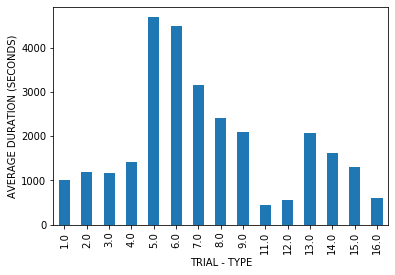

In [10]:
#Plot the average duration of each trial
data_aggregated_trial.iloc[:,0].plot.bar() #all coumns are equal. We will use only the first (0 index) columns
plt.ylabel("AVERAGE DURATION (SECONDS)")
plt.xlabel("TRIAL - TYPE")
plt.show()

In [11]:
data['accMagnitude'] = np.sqrt(data['userAcceleration.x']*data['userAcceleration.x'] + data['userAcceleration.y']*data['userAcceleration.y'] +data['userAcceleration.z']*data['userAcceleration.z']) 

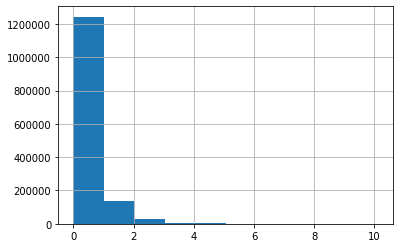

In [12]:
data['accMagnitude'].hist()
plt.show()

### 1.3 TO DOs
- How many participants are females/males? [0:Female, 1:Male]
- Plot the average acceleration magnitude per activity type. What do you notice?

In [13]:
#your code goes here
#How many participants are females/males? [0:Female, 1:Male]

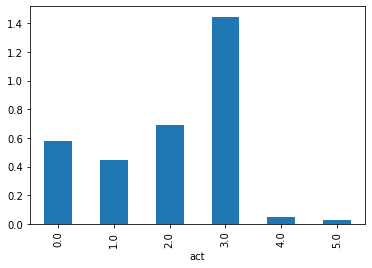

In [14]:
#your code goes here
#Plot the average acceleration magnitude per activity type. What do you notice?

data.groupby('act').mean().accMagnitude.plot.bar()
plt.show()

## 2. Data segmentation (windowing) and filtering

1. Visualize some acceleration data from the first participant (his first trial).
2. Visualize the impact of mean-filtering and low-pass filtering in time domain.
3. Visualize the impact of mean-filtering and low-pass filtering in frequency domain.
4. Create a function for signal segmentation and filtering.

First participant data shape (62312, 20)
First trial of the first participant data shape (1751, 20)


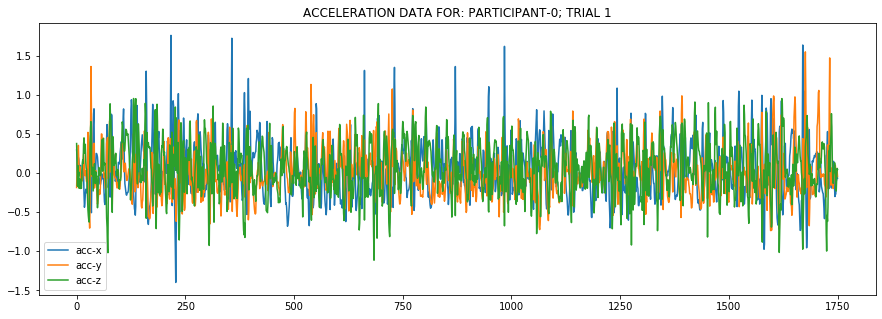

In [15]:
#get the data form the first participant
first_p = data[data.id==0]
print('First participant data shape',first_p.shape)
#get the data form the first trial of the first participant
trial = first_p[first_p.trial==1]
print('First trial of the first participant data shape',trial.shape)

#plot the accelreation data for the first trial
plt.figure(figsize = (15,5))
plt.plot(trial['userAcceleration.x'],label = 'acc-x')
plt.plot(trial['userAcceleration.y'],label = 'acc-y')
plt.plot(trial['userAcceleration.z'],label = 'acc-z')
plt.legend()
plt.title("ACCELERATION DATA FOR: PARTICIPANT-0; TRIAL 1")
plt.show()


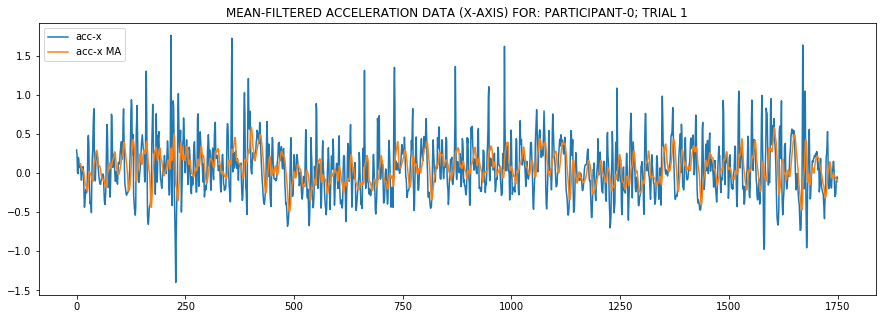

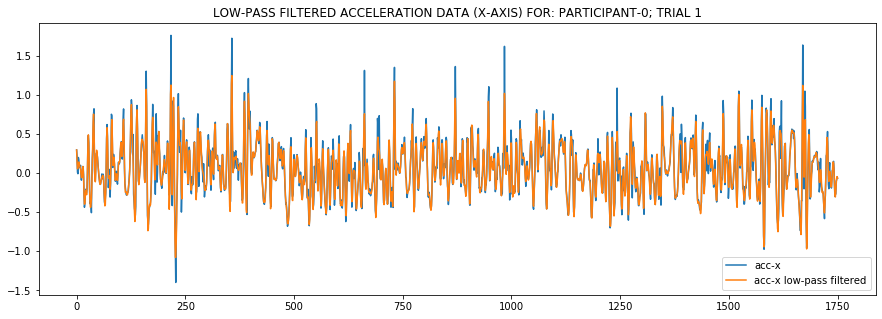

In [16]:
#Visualize the impact of mean-filtering and low-pass filtering in time domain
#plot mean-filtered accelreation data
plt.figure(figsize = (15,5))
plt.plot(trial['userAcceleration.x'],label = 'acc-x')
plt.plot(trial['userAcceleration.x'].rolling(window=10).mean(),label = 'acc-x MA') #moving window with a size of 10 samples
plt.legend()
plt.title("MEAN-FILTERED ACCELERATION DATA (X-AXIS) FOR: PARTICIPANT-0; TRIAL 1")
plt.show()


#plot low-pass filtered accelreation data
plt.figure(figsize = (15,5))
segment = trial['userAcceleration.x'].values
plt.plot(segment,label = 'acc-x')
fs = 50  # Sampling frequency
fc = 10  # Cut-off frequency of the filter
w = fc / (fs / 2) # Normalize the frequency
n= 5 #The order of the filter.
b, a = signal.butter(n, w, 'low')
output = signal.filtfilt(b, a, segment)
plt.plot(output, label='acc-x low-pass filtered')
plt.legend()
plt.title("LOW-PASS FILTERED ACCELERATION DATA (X-AXIS) FOR: PARTICIPANT-0; TRIAL 1")
plt.show()


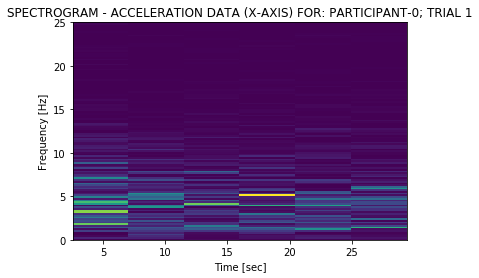

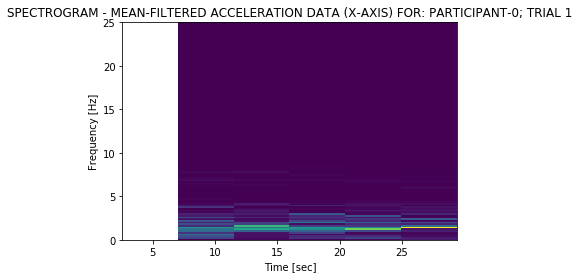

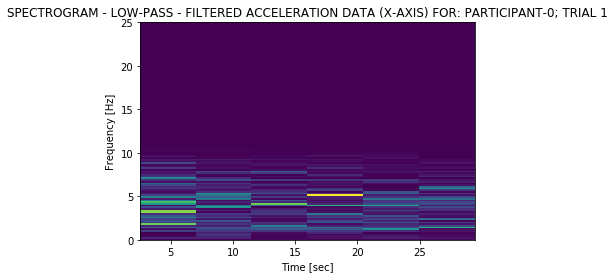

In [17]:
#Visualize the impact of mean-filtering and low-pass filtering in frequency domain
segment = trial['userAcceleration.x'].values
sampling_frequency = 50
frequencies, time, spec = signal.spectrogram(segment, sampling_frequency)
plt.pcolormesh(time, frequencies, spec)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("SPECTROGRAM - ACCELERATION DATA (X-AXIS) FOR: PARTICIPANT-0; TRIAL 1")
plt.show()

segment_mean = trial['userAcceleration.x'].rolling(window=10).mean()
frequencies, time, spec = signal.spectrogram(segment_mean, sampling_frequency)
plt.pcolormesh(time, frequencies, spec)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("SPECTROGRAM - MEAN-FILTERED ACCELERATION DATA (X-AXIS) FOR: PARTICIPANT-0; TRIAL 1")
plt.show()


fs = 50  # Sampling frequency
fc = 10# Cut-off frequency of the filter
w = fc / (fs / 2) # Normalize the frequency
n= 5 #The order of the filter.
b, a = signal.butter(n, w, 'low')
segment_low_pass = signal.filtfilt(b, a, segment)
frequencies, time, spec = signal.spectrogram(segment_low_pass, sampling_frequency)
plt.pcolormesh(time, frequencies, spec)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("SPECTROGRAM - LOW-PASS - FILTERED ACCELERATION DATA (X-AXIS) FOR: PARTICIPANT-0; TRIAL 1")
plt.show()

In [42]:
#Create a function for signal segmentation and filtering.
def low_pass_filter(segment):
    fs = 50  # Sampling frequency
    fc = 5  # Cut-off frequency of the filter
    w = fc / (fs / 2) # Normalize the frequency
    n= 5 #The order of the filter.
    b, a = signal.butter(n, w, 'low')
    output = signal.filtfilt(b, a, segment)
    return output

#the function takes as input a sinal (pandas timeseries) 
#and the size of the window (default 4 seconds)to be used for the segmentation
#the function filters the signal and returns a list of segments
def segment_filter(trial, window_size=4*50):
    trial_f  = low_pass_filter(trial.values) 
    #segment the data
    win_start = 0
    win_end = win_start+window_size
    segments = []
    while win_end<len(trial_f):
        segment = trial_f[win_start:win_end]
        segments.append(segment)
        #move/slide the window
        win_start = win_start +int(window_size/2)
        win_end = win_start+window_size
#         print(win_start)
#         print(win_end)
       
    return segments

#iterate through the data of each participant and each trial and perform segmentation
for participant in data.id.unique():
    data_p = data[data.id==participant]
    print("Segmenting data for participant:", participant)
    print("Participant data shape:", data_p.shape)
    for trial in data_p.trial.unique():
        data_p_t = data_p[data_p.trial==trial]
        print("Trial data shape:", data_p_t.shape)
        for sensor_axis in sensor_columns:
            print("Segmenting sensor-axis:", sensor_axis)
            segment_array = segment_filter(data_p_t[sensor_axis])
            print("Number of segments, segment length:", np.array(segment_array).shape)
        print('-')
    print('---------')

Segmenting data for participant: 0.0
Participant data shape: (62312, 20)
Trial data shape: (1751, 20)
Segmenting sensor-axis: attitude.roll
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: attitude.pitch
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (16, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments,

Number of segments, segment length: (101, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length: (101, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (101, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (101, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (101, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (101, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (101, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (101, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (101, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (101, 200)
Segmenting sensor-axis: userAcceleration.z
Number of segments, segment length: (101, 200)
-
---------
Segmenting data for participant: 1.0
Participant data shape: (62339, 20)
Trial data sh

Trial data shape: (9220, 20)
Segmenting sensor-axis: attitude.roll
Number of segments, segment length: (91, 200)
Segmenting sensor-axis: attitude.pitch
Number of segments, segment length: (91, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length: (91, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (91, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (91, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (91, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (91, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (91, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (91, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (91, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (91, 200)
Segmenting sensor-axis: userAcceleration.z
Num

Number of segments, segment length: (122, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (122, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (122, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (122, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (122, 200)
Segmenting sensor-axis: userAcceleration.z
Number of segments, segment length: (122, 200)
-
Trial data shape: (1894, 20)
Segmenting sensor-axis: attitude.roll
Number of segments, segment length: (17, 200)
Segmenting sensor-axis: attitude.pitch
Number of segments, segment length: (17, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length: (17, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (17, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (17, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length

Number of segments, segment length: (29, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (29, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (29, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (29, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (29, 200)
Segmenting sensor-axis: userAcceleration.z
Number of segments, segment length: (29, 200)
-
---------
Segmenting data for participant: 4.0
Participant data shape: (52283, 20)
Trial data shape: (2187, 20)
Segmenting sensor-axis: attitude.roll
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: attitude.pitch
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (

Number of segments, segment length: (20, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: userAcceleration.z
Number of segments, segment length: (20, 200)
-
Trial data shape: (2484, 20)
Segmenting sensor-axis: attitude.roll
Number of segments, segment length: (23, 200)
Segmenting sensor-axis: attitude.pitch
Number of segments, segment length: (23, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length:

Number of segments, segment length: (17, 200)
Segmenting sensor-axis: attitude.pitch
Number of segments, segment length: (17, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length: (17, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (17, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (17, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (17, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (17, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (17, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (17, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (17, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (17, 200)
Segmenting sensor-axis: userAcceleration.z
Number of segments, segment length: (17, 200)
-
Trial data shape: (222

Number of segments, segment length: (112, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (112, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (112, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (112, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (112, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (112, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (112, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (112, 200)
Segmenting sensor-axis: userAcceleration.z
Number of segments, segment length: (112, 200)
-
Trial data shape: (4918, 20)
Segmenting sensor-axis: attitude.roll
Number of segments, segment length: (48, 200)
Segmenting sensor-axis: attitude.pitch
Number of segments, segment length: (48, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segmen

Number of segments, segment length: (46, 200)
Segmenting sensor-axis: attitude.pitch
Number of segments, segment length: (46, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length: (46, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (46, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (46, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (46, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (46, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (46, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (46, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (46, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (46, 200)
Segmenting sensor-axis: userAcceleration.z
Number of segments, segment length: (46, 200)
-
---------
Segmenting d

Segmenting data for participant: 9.0
Participant data shape: (59796, 20)
Trial data shape: (2678, 20)
Segmenting sensor-axis: attitude.roll
Number of segments, segment length: (25, 200)
Segmenting sensor-axis: attitude.pitch
Number of segments, segment length: (25, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length: (25, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (25, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (25, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (25, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (25, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (25, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (25, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (25, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments,

Trial data shape: (2742, 20)
Segmenting sensor-axis: attitude.roll
Number of segments, segment length: (26, 200)
Segmenting sensor-axis: attitude.pitch
Number of segments, segment length: (26, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length: (26, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (26, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (26, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (26, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (26, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (26, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (26, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (26, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (26, 200)
Segmenting sensor-axis: userAcceleration.z
Num

Number of segments, segment length: (7, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (7, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (7, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (7, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (7, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (7, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (7, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (7, 200)
Segmenting sensor-axis: userAcceleration.z
Number of segments, segment length: (7, 200)
-
Trial data shape: (2249, 20)
Segmenting sensor-axis: attitude.roll
Number of segments, segment length: (21, 200)
Segmenting sensor-axis: attitude.pitch
Number of segments, segment length: (21, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length: (21, 200

Number of segments, segment length: (8, 200)
Segmenting sensor-axis: userAcceleration.z
Number of segments, segment length: (8, 200)
-
Trial data shape: (1512, 20)
Segmenting sensor-axis: attitude.roll
Number of segments, segment length: (14, 200)
Segmenting sensor-axis: attitude.pitch
Number of segments, segment length: (14, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length: (14, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (14, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (14, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (14, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (14, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (14, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (14, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (14, 200)


Number of segments, segment length: (9, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length: (9, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (9, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (9, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (9, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (9, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (9, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (9, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (9, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (9, 200)
Segmenting sensor-axis: userAcceleration.z
Number of segments, segment length: (9, 200)
-
Trial data shape: (6767, 20)
Segmenting sensor-axis: attitude.roll
Number of segments, segment length: (66, 200)
Segme

Number of segments, segment length: (68, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length: (68, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (68, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (68, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (68, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (68, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (68, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (68, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (68, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (68, 200)
Segmenting sensor-axis: userAcceleration.z
Number of segments, segment length: (68, 200)
-
Trial data shape: (4906, 20)
Segmenting sensor-axis: attitude.roll
Number of segments, segment length: (48,

Number of segments, segment length: (53, 200)
Segmenting sensor-axis: attitude.pitch
Number of segments, segment length: (53, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length: (53, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (53, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (53, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (53, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (53, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (53, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (53, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (53, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (53, 200)
Segmenting sensor-axis: userAcceleration.z
Number of segments, segment length: (53, 200)
-
Trial data shape: (274

Number of segments, segment length: (21, 200)
Segmenting sensor-axis: attitude.pitch
Number of segments, segment length: (21, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length: (21, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (21, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (21, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (21, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (21, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (21, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (21, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (21, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (21, 200)
Segmenting sensor-axis: userAcceleration.z
Number of segments, segment length: (21, 200)
-
Trial data shape: (337

Trial data shape: (4856, 20)
Segmenting sensor-axis: attitude.roll
Number of segments, segment length: (47, 200)
Segmenting sensor-axis: attitude.pitch
Number of segments, segment length: (47, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length: (47, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (47, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (47, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (47, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (47, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (47, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (47, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (47, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (47, 200)
Segmenting sensor-axis: userAcceleration.z
Num

Number of segments, segment length: (11, 200)
Segmenting sensor-axis: attitude.pitch
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (11, 200)
Segmenting sensor-axis: userAcceleration.z
Number of segments, segment length: (11, 200)
-
Trial data shape: (164

Number of segments, segment length: (12, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (12, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (12, 200)
Segmenting sensor-axis: userAcceleration.z
Number of segments, segment length: (12, 200)
-
Trial data shape: (9679, 20)
Segmenting sensor-axis: attitude.roll
Number of segments, segment length: (95, 200)
Segmenting sensor-axis: attitude.pitch
Number of segments, segment length: (95, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length: (95, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (95, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (95, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (95, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (95, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (95,

Number of segments, segment length: (103, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (103, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (103, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (103, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (103, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (103, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (103, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (103, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (103, 200)
Segmenting sensor-axis: userAcceleration.z
Number of segments, segment length: (103, 200)
-
Trial data shape: (3836, 20)
Segmenting sensor-axis: attitude.roll
Number of segments, segment length: (37, 200)
Segmenting sensor-axis: attitude.pitch
Number of segments, segment 

Number of segments, segment length: (75, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (75, 200)
Segmenting sensor-axis: userAcceleration.z
Number of segments, segment length: (75, 200)
-
Trial data shape: (5779, 20)
Segmenting sensor-axis: attitude.roll
Number of segments, segment length: (56, 200)
Segmenting sensor-axis: attitude.pitch
Number of segments, segment length: (56, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length: (56, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (56, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (56, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (56, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (56, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (56, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (56, 200

Number of segments, segment length: (20, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (20, 200)
Segmenting sensor-axis: userAcceleration.z
Number of segments, segment length: (20, 200)
-
Trial data shape: (6106, 20)
Segmenting sensor-axis: attitude.roll
Number of segments, segment length: (60, 200)
Segmenting sensor-axis: attitude.pitch
Number of segments, segment length: (60, 200)
Segmenting sensor-axis: attitude.yaw
Number of segments, segment length: (60, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (60, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (60, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (60, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (60, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (60, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (60, 200

Number of segments, segment length: (32, 200)
Segmenting sensor-axis: gravity.x
Number of segments, segment length: (32, 200)
Segmenting sensor-axis: gravity.y
Number of segments, segment length: (32, 200)
Segmenting sensor-axis: gravity.z
Number of segments, segment length: (32, 200)
Segmenting sensor-axis: rotationRate.x
Number of segments, segment length: (32, 200)
Segmenting sensor-axis: rotationRate.y
Number of segments, segment length: (32, 200)
Segmenting sensor-axis: rotationRate.z
Number of segments, segment length: (32, 200)
Segmenting sensor-axis: userAcceleration.x
Number of segments, segment length: (32, 200)
Segmenting sensor-axis: userAcceleration.y
Number of segments, segment length: (32, 200)
Segmenting sensor-axis: userAcceleration.z
Number of segments, segment length: (32, 200)
-
---------


In [35]:
segment_array = segment_filter(data_p_t[sensor_axis])
segment_array

[array([ 0.04446374,  0.03649603,  0.02852081,  0.02052515,  0.01250295,
         0.00456901, -0.0029139 , -0.00929782, -0.01376599, -0.01557656,
        -0.01433102, -0.01015122, -0.00369562,  0.00398642,  0.01170861,
         0.01842569,  0.02344589,  0.02650997,  0.02771734,  0.02734173,
         0.02562663,  0.0226589 ,  0.01838029,  0.01272904,  0.00584266,
        -0.0017712 , -0.00917147, -0.01506604, -0.01804214, -0.01691806,
        -0.01115202, -0.00119764,  0.01133702,  0.0238515 ,  0.03327196,
         0.03682394,  0.03282405,  0.02120657,  0.00358089, -0.01719398,
        -0.03772672, -0.0548097 , -0.06590089, -0.06931741, -0.06425802,
        -0.05082899, -0.03016445, -0.00457655,  0.02244534,  0.04655655,
         0.06323846,  0.06870867,  0.0608184 ,  0.03968254,  0.00785968,
        -0.02997716, -0.06780538, -0.09928035, -0.11881338, -0.1225028 ,
        -0.10877031, -0.07862516, -0.03555786,  0.01488032,  0.06575845,
         0.10969722,  0.14004601,  0.15219871,  0.1

### 2.2 TO DOs
- Using the same code for spectrogram visualization, visualize the impact of the low-pass filtering for a cut-off frequency of 1 and 10 Hz.
- Update the function "segment_filter" so that it segments the singal with a 50% overlap.

In [18]:
#your code goes here
#Visualize the impact of the low-pass filtering 


In [19]:
#your code goes here
#Update the function "segment_filter" so that it segments the singal with a 50% overlap.

### Further reading
- Pandas as time-series: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
- Data visualization: https://elitedatascience.com/python-seaborn-tutorial
- Filtering: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.butter.html
- Spectrogram: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
-  More info about the dataset and analysis performed over it:
http://doi.acm.org/10.1145/3302505.3310068 (Malekzadeh et al. "Mobile sensor data anonymization", Proceedings of the International Conference on Internet of Things Design and Implementation, 2019).